In [1]:
import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

# Context-Based Series Prediction




In [2]:
class DataTable: pass
train_table = joblib.load("prepared_data/train_data.jbl")
test_table = joblib.load("prepared_data/test_data.jbl")

if not os.path.exists("images/regress"):
    os.makedirs("images/regress")

## Metrics

In [3]:
class MetricHolder:
    def __init__(self, holder_name):
        self.name = holder_name
        self.storage = defaultdict(list)
        self.algo2estimator = dict()
        
    def commit(self, algo_name, algo_performance, best_estimator):
        name_tokens = algo_name.strip().split("_")
        title_tokens = [item.capitalize() for item in name_tokens]
        algo_title = " ".join(title_tokens[:-2])
        target_title = " ".join(title_tokens[-2:])
        if algo_name == "baseline":
            algo_title = "Baseline"
            target_title = "Id Exact"
        self.storage['Algorithm'].append(algo_title)
        self.storage['Target Form'].append(target_title)
        self.algo2estimator[algo_name] = best_estimator
        for metric, value in algo_performance.items():
            self.storage[metric].append(value)
            
    def make_table(self):
        return pd.DataFrame.from_dict(self.storage)
    
    def export_to_csv(self):
        table = self.make_table()
        table.to_csv("tables/" + self.name + ".csv")
    
    def export_to_tex(self):
        table = self.make_table()
        table.to_latex("tables/" + self.name + ".tex",  float_format="%.2f")
        
    def export_to_xlsx(self):
        table = self.make_table()
        table.to_excel("tables/" + self.name + ".xlsx", float_format="%.2f")
        

value_prediction_metrics = MetricHolder("value_prediction_metrics") 
percent_prediction_metrics = MetricHolder("percent_prediction_metrics")

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, explained_variance_score

def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
    

def compute_metrics(y_true, y_pred):
    metric_info = {}
    for name, metric in zip(["MAE", "RMSE", "MAXERR", "EXPVAR"], [
                mean_absolute_error, root_mean_squared_error, max_error, explained_variance_score]):
        metric_info[name] = metric(y_true, y_pred)
    return metric_info


## Baseline: Return Scheduled


In [5]:
exact_baseline_score = compute_metrics(test_table.matrix['REPAYMENT_ACTUAL'], test_table.matrix['REPAYMENT_SCHEDULED'])
percent_baseline_score = compute_metrics(test_table.matrix['PERCENT_ACTUAL'], test_table.matrix['RELATIVE_REPAYMENT_SCHEDULED'])

value_prediction_metrics.commit("baseline", exact_baseline_score, None)
percent_prediction_metrics.commit("baseline", percent_baseline_score, None)

## General Precomputations

In [6]:
y_train_id_exact = copy.deepcopy(train_table.matrix[train_table.id_target_exact_key])
y_train_log_exact = copy.deepcopy(train_table.matrix[train_table.log_target_exact_key])
y_train_id_relative = copy.deepcopy(train_table.matrix[train_table.id_target_relative_key])
y_train_log_relative = copy.deepcopy(train_table.matrix[train_table.log_target_relative_key])

X_train = copy.deepcopy(train_table.matrix).drop(train_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)


y_test_id_exact = copy.deepcopy(test_table.matrix[test_table.id_target_exact_key])
y_test_log_exact = copy.deepcopy(test_table.matrix[test_table.log_target_exact_key])
y_test_id_relative = copy.deepcopy(test_table.matrix[test_table.id_target_relative_key])
y_test_log_relative = copy.deepcopy(test_table.matrix[test_table.log_target_relative_key])

X_test = copy.deepcopy(test_table.matrix).drop(test_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)


## 1. Linear Models

In [7]:
def perform_grid_search(estimator, param_grid, experiment_name):
    cv_est = GridSearchCV(estimator, param_grid, cv=3)
    
    # Exact prediction.
    cv_est.fit(X_train, y_train_id_exact)
    y_pred = cv_est.predict(X_test)
    value_prediction_metrics.commit(
        experiment_name + "_id_exact",
        compute_metrics(y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_id_exact",
        compute_metrics(y_test_id_relative, y_pred / X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Log-Exact prediction.
    cv_est.fit(X_train, y_train_log_exact)
    y_pred = np.expm1(cv_est.predict(X_test))
    value_prediction_metrics.commit(
        experiment_name + "_log_exact",
        compute_metrics(y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_log_exact",
        compute_metrics(y_test_id_relative, y_pred / X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Relative prediction.
    cv_est.fit(X_train, y_train_id_relative)
    y_pred = cv_est.predict(X_test) * X_test['CONTRACT_SUM'] / 100
    value_prediction_metrics.commit(
        experiment_name + "_id_relative",
        compute_metrics(y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_id_relative",
        compute_metrics(y_test_id_relative, y_pred / X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Log-Relative prediction.
    cv_est.fit(X_train, y_train_log_relative)
    y_pred = np.expm1(cv_est.predict(X_test)) * X_test['CONTRACT_SUM'] / 100
    value_prediction_metrics.commit(
        experiment_name + "_log_relative",
        compute_metrics(y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_log_relative",
        compute_metrics(y_test_id_relative, y_pred / X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
ridge_grid = {
    'alpha': [0.01, 0.01, 0.1, 0.5, 1.0, 10.0, 20.0],
    'normalize': [True, False],
}
ridge_est = Ridge(alpha=0.1)
perform_grid_search(ridge_est, ridge_grid, 'ridge_regression')

In [9]:
from sklearn.linear_model import Lasso
lasso_est = Lasso(alpha=0.1, max_iter=10000)
lasso_grid = {
    'alpha' : [0.01, 0.1, 1.0, 10.0, 20.0],
    'normalize': ['True', 'False'],    
}
perform_grid_search(lasso_est, lasso_grid, 'lasso_regression')

In [10]:
from sklearn.linear_model import HuberRegressor
est_huber = HuberRegressor(alpha=0.1, max_iter=1000)
huber_grid = {
    'alpha': [0.01, 1.0, 10.0]
}
perform_grid_search(est_huber, huber_grid, 'huber_regression')

C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

In [11]:
from sklearn.linear_model import BayesianRidge
est_bayesian = BayesianRidge(n_iter=400)
bayesian_grid = {
    'normalize': [True, False],
    'n_iter': [400, 500, 600],
}
perform_grid_search(est_bayesian, bayesian_grid, 'bayesian_regression')

# 2. Tree-Based Ensemble Models

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf_param_grid = {
    'n_estimators' : [100],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 10]
}
est_rf = RandomForestRegressor(n_jobs=-1)
perform_grid_search(est_rf, rf_param_grid, "random_forest")

In [13]:
import xgboost
xgboost_params = {
    'learning_rate': [0.01],
    'max_depth': [10, 30],
    'n_estimators': [100],
    'reg_alpha': [0.05],
    'reg_lambda': [0.45],
    'booster': ['gbtree', 'dart'],
}
xgb_model = xgboost.XGBRegressor(               
    learning_rate=0.01, max_depth=4, n_estimators=500,                                                                    
    reg_alpha=0.5, reg_lambda=0.45, seed=42, n_jobs=12)
perform_grid_search(xgb_model, xgboost_params, "xgboost")

## 3. Sklearn MLP Regressor

In [14]:
from sklearn.neural_network import MLPRegressor
nn_params = {
    'hidden_layer_sizes':  [(128), (64), (32, 32)],
    'alpha' : [0.01]
}
nn_est = MLPRegressor(max_iter=10000)
perform_grid_search(nn_est, nn_params, "sklearn_neural_net")

## 4. Support Vector Regression

In [15]:
from sklearn.svm import SVR
svr_est = SVR(C=10.0, gamma='auto')
svr_params = {
    "C": [5.0],
    "gamma": ['scale'],
    "cache_size": [15000],
    "max_iter": [5000]
}
perform_grid_search(svr_est, svr_params, "svr")

C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\nekrald\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

# 5. KNN

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

knn_params = {'knn__n_neighbors': [5, 10, 15]}
knn_model = Pipeline(steps= [('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])

perform_grid_search(knn_model, knn_params, 'knn_regressor')

In [17]:
value_prediction_metrics.export_to_tex()
value_prediction_metrics.export_to_csv()
value_prediction_metrics.export_to_xlsx()
value_prediction_metrics.make_table()

,Algorithm,Target Form,MAE,RMSE,MAXERR,EXPVAR
0,Baseline,Id Exact,26.380093,98.946429,1947.340000,1.250167e-02
1,Ridge Regression,Id Exact,29.395174,93.345523,1867.763053,7.488418e-02
2,Ridge Regression,Log Exact,22.939692,95.138580,1897.169998,6.601448e-02
3,Ridge Regression,Id Relative,29.986783,93.188893,1840.458272,7.791547e-02
4,Ridge Regression,Log Relative,22.572190,94.117379,1880.578798,7.614373e-02
5,Lasso Regression,Id Exact,31.331168,94.095952,1884.099735,6.002831e-02
6,Lasso Regression,Log Exact,31.857412,100.034125,1948.598076,-4.440892e-16
7,Lasso Regression,Id Relative,44.180329,98.769683,1865.037708,-2.879912e-02
8,Lasso Regression,Log Relative,34.792590,98.839352,1916.247718,-1.257779e-02
9,Huber Regression,Id Exact,23.140611,95.750573,1918.167347,5.360648e-02


In [18]:
percent_prediction_metrics.export_to_csv()
percent_prediction_metrics.export_to_tex()
percent_prediction_metrics.export_to_xlsx()
percent_prediction_metrics.make_table()

,Algorithm,Target Form,MAE,RMSE,MAXERR,EXPVAR
0,Baseline,Id Exact,2.314208,7.711478,99.173700,0.032126
1,Ridge Regression,Id Exact,2.453963,7.075056,99.299716,0.133426
2,Ridge Regression,Log Exact,1.945600,7.278206,98.964411,0.114408
3,Ridge Regression,Id Relative,2.480036,7.083142,99.387644,0.131396
4,Ridge Regression,Log Relative,1.909730,7.197327,99.021431,0.123661
5,Lasso Regression,Id Exact,2.666097,7.188330,98.307360,0.105932
6,Lasso Regression,Log Exact,2.811763,7.781552,99.044109,0.028616
7,Lasso Regression,Id Relative,3.428801,7.500937,96.546976,0.025795
8,Lasso Regression,Log Relative,3.015005,7.797025,98.131989,0.000000
9,Huber Regression,Id Exact,1.964405,7.327322,98.964445,0.102052


Random Forest log-relative shows the best MAE performance.

# Algorithm-based Visualizations

1. Visualization of Lasso coefficients.
2. Visualization of Ridge coefficients.
3. Feature importances in Random Forest.
4. Feature importances in xgboost.

In [19]:
all_dropna_table = joblib.load("prepared_data/all_data_dropped_na.jbl")

y_all_id_exact = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.id_target_exact_key])
y_all_log_exact = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.log_target_exact_key])
y_all_id_relative = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.id_target_relative_key])
y_all_log_relative = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.log_target_relative_key])

X_all = copy.deepcopy(all_dropna_table.matrix).drop(
    all_dropna_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)

In [20]:
import seaborn as sns

def plot_linear_coefficients(X_train, linear_model, title, shrink=None, x_figure_shift=0):
    linear_df = pd.DataFrame()
    columns = copy.deepcopy(X_train.columns.tolist())
    for idx, entry in enumerate(columns):
        columns[idx] = columns[idx].replace("_", "\n")
        columns[idx] = columns[idx].replace("DOWNPAYMENT", "DWNPMT")
        columns[idx] = columns[idx].replace("REPAYMENT", "RePMNT")
        columns[idx] = columns[idx].replace("SCHEDULED", "SchDLD")
    linear_df['columns'] = columns
    linear_df['weights'] = linear_model.coef_
    if shrink is not None:
        linear_df = linear_df[np.abs(linear_df['weights']) > shrink]
    plt.rcParams["figure.figsize"] = (20 + x_figure_shift, 10)
    ax = sns.barplot(x='columns', y='weights', data=linear_df)
    plt.title(title)
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", dpi=300, bbox_inches='tight')
    

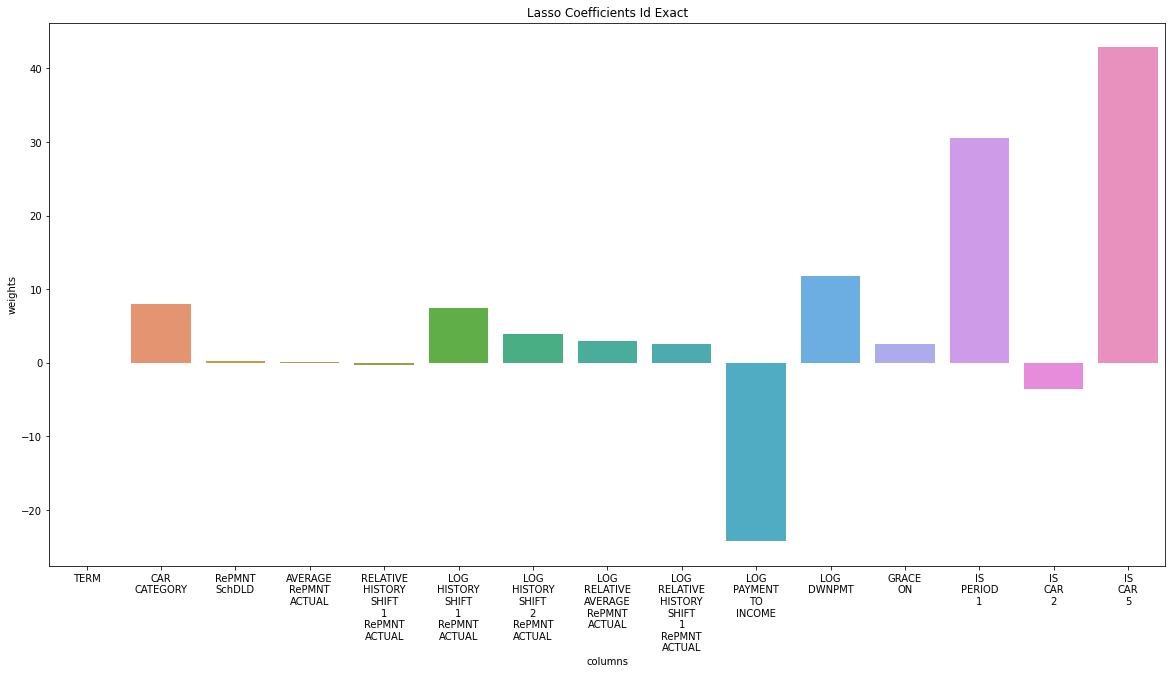

In [21]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['lasso_regression_id_exact'], 
    "Lasso Coefficients Id Exact", shrink=0.01)

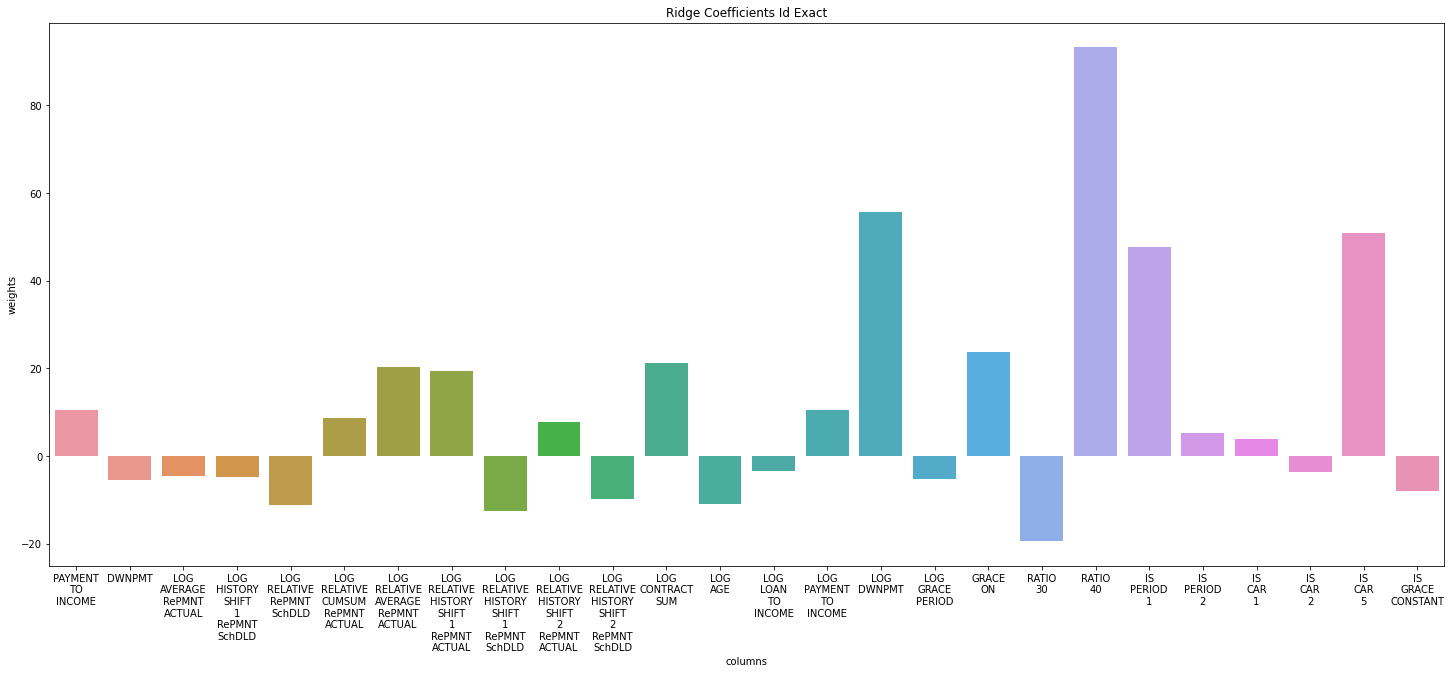

In [22]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['ridge_regression_id_exact'],
    "Ridge Coefficients Id Exact", shrink=3.0, x_figure_shift=5)

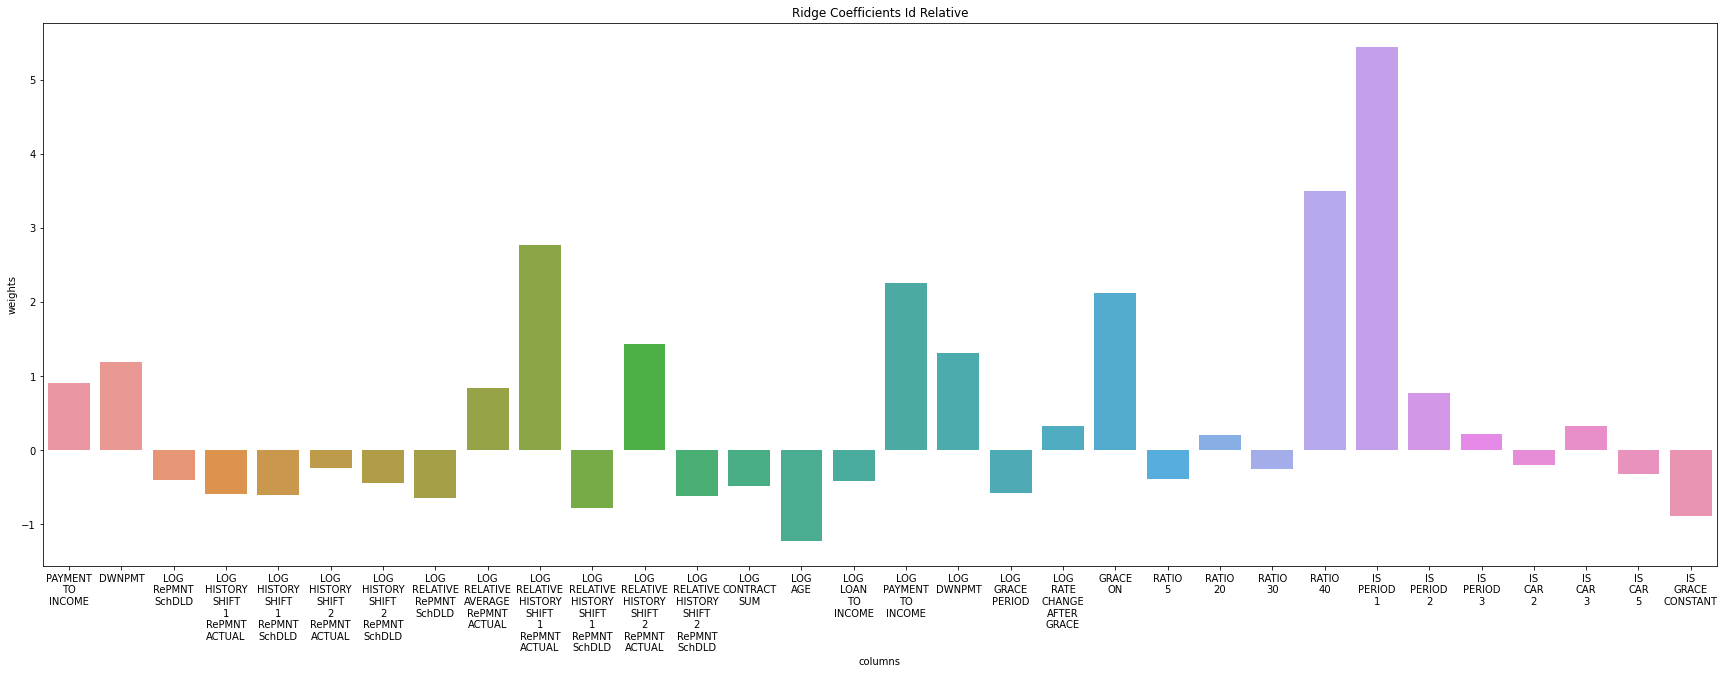

In [23]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['ridge_regression_id_relative'],
    "Ridge Coefficients Id Relative", shrink=0.2, x_figure_shift=10)

In [24]:
from xgboost import plot_importance

def plot_xgboost_importances(xgboost_model, title):
    plt.rcParams["figure.figsize"] = (14, 7)
    plot_importance(xgboost_model, height=0.2)
    plt.title(title)
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", dpi=300, bbox_inches='tight')


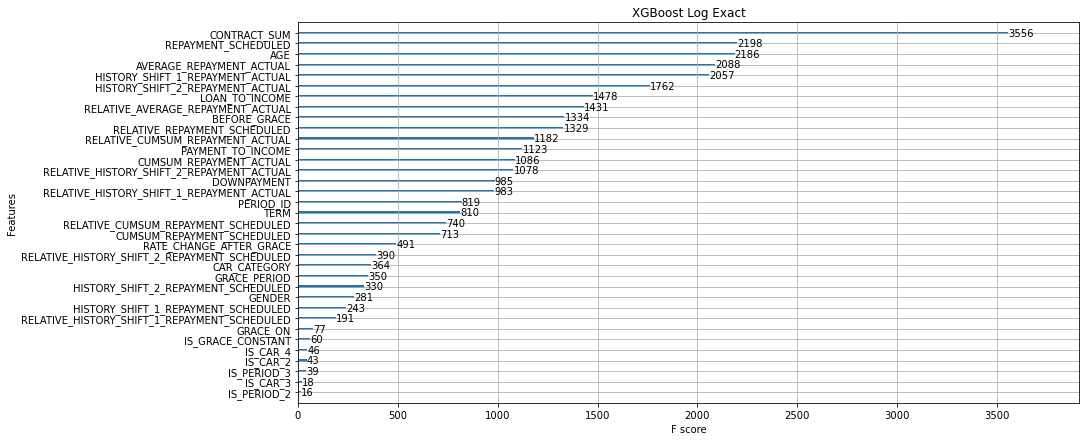

In [25]:
plot_xgboost_importances(percent_prediction_metrics.algo2estimator['xgboost_log_exact'], "XGBoost Log Exact")

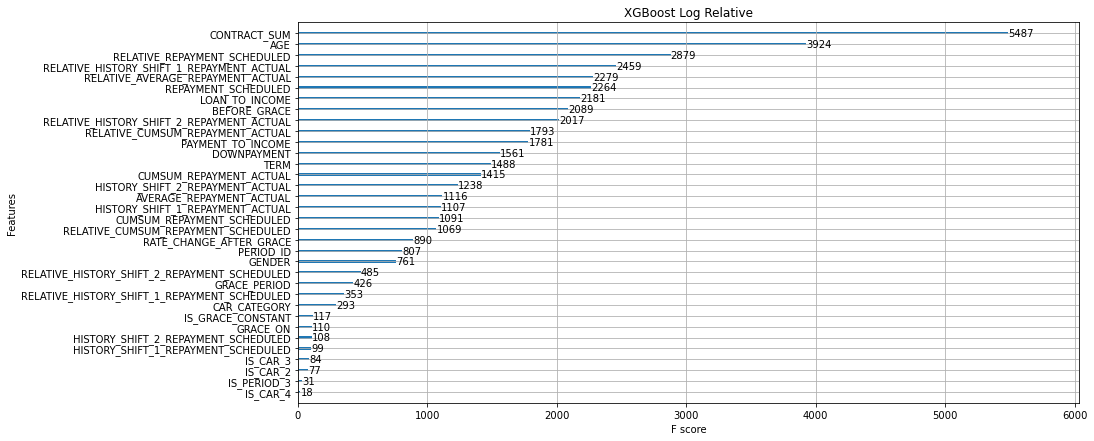

In [26]:
plot_xgboost_importances(percent_prediction_metrics.algo2estimator['xgboost_log_relative'], "XGBoost Log Relative")

In [27]:
import seaborn as sns

def plot_random_forest_importances(X_train, rf_model, title, threshold):
    columns = copy.deepcopy(X_train.columns).tolist()
    for idx in range(len(columns)):
        columns[idx] = columns[idx].replace("_", "\n")
        columns[idx] = columns[idx].replace("DOWNPAYMENT", "DWNPMT")
        columns[idx] = columns[idx].replace("REPAYMENT", "RePMNT")
        columns[idx] = columns[idx].replace("SCHEDULED", "SchDLD")
    df = pd.DataFrame.from_dict({
        'importance' : rf_model.feature_importances_,
        'feature'     : columns
    })
    if threshold is not None:
        df = df[df['importance'] > threshold]
    df = df.sort_values(by='importance', ascending=False)
    plt.figure(figsize=(35,5))
    sns.barplot(data=df, x='feature', y='importance')
    plt.title(title)
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", dpi=300, bbox_inches='tight')

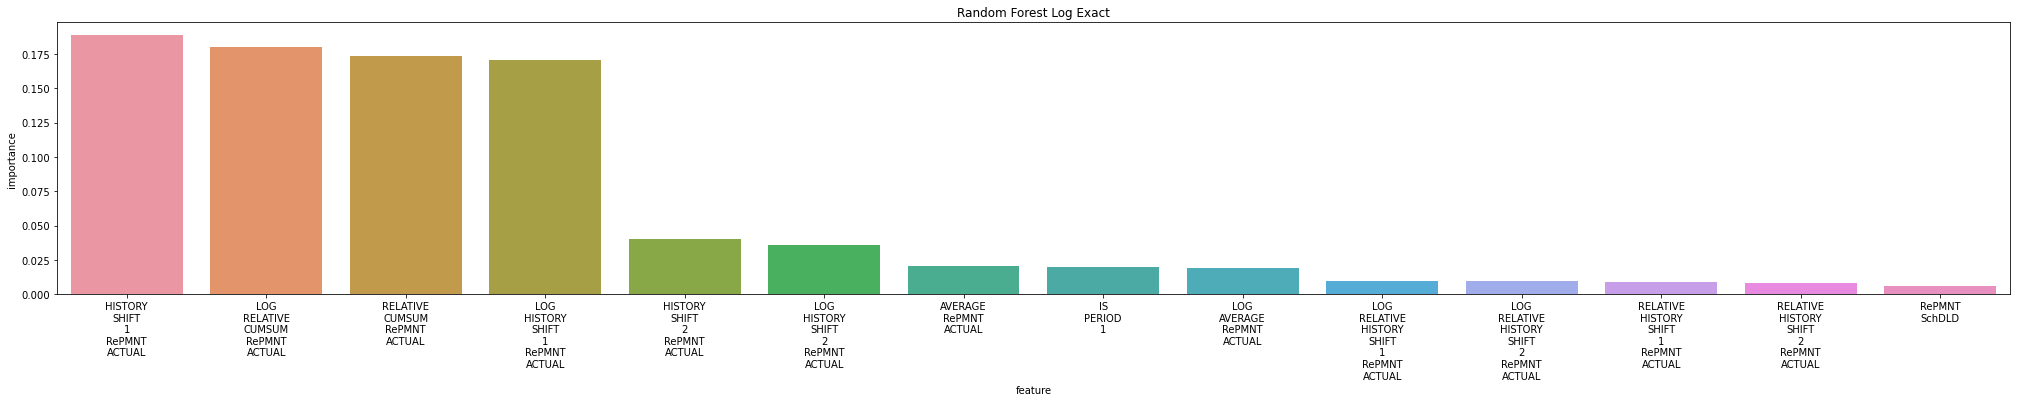

In [28]:
plot_random_forest_importances(
    X_train, percent_prediction_metrics.algo2estimator['random_forest_log_exact'], 
    "Random Forest Log Exact", 0.006)

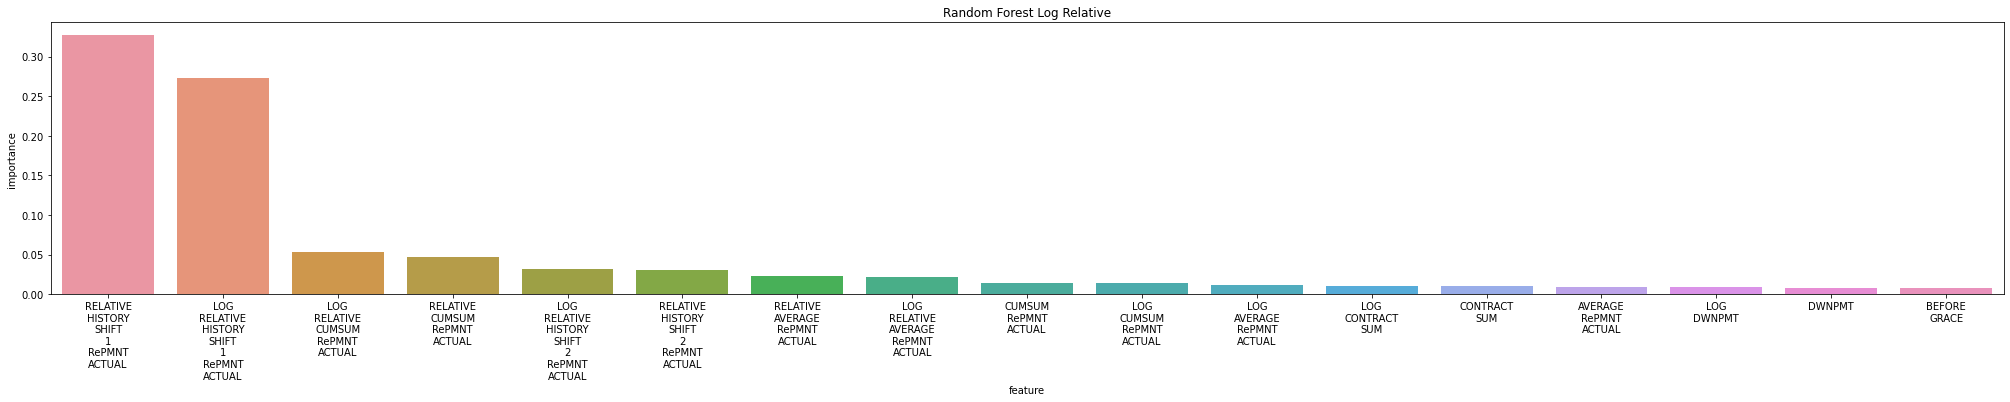

In [29]:
plot_random_forest_importances(
    X_train, percent_prediction_metrics.algo2estimator['random_forest_log_relative'], 
    "Random Forest Log Relative", 0.007)

Saving the best performing algorithm for relative series completion.

In [30]:
best_rf = value_prediction_metrics.algo2estimator['random_forest_log_relative']
best_rf.fit(X_all, y_all_log_relative)
joblib.dump(best_rf, 'algorithms/rf-log-relative.jbl')

['algorithms/rf-log-relative.jbl']